In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [385]:
# Define the path to the MadGraph directory
path_to_madgraph = os.path.expanduser('~/Development/MG5_aMC_v3_5_0')  # Change this to your MadGraph installation path
notebook_path = os.getcwd( )

# Change the current directory to the MadGraph directory
os.chdir(path_to_madgraph)

# Create a command file with all the instructions for MadGraph
mg5_commands = """
import model ExoticMuonCaptureModel1
generate pp > e+ vm~ ve vm chi1 e+ e- QEDp=5
output ProtonDecayModel1
launch ProtonDecayModel1
set nevents 50000
"""

# Save the commands to a file
with open('mg5_script.txt', 'w') as file:
    file.write(mg5_commands)

# Run the MadGraph script
os.system(f'{path_to_madgraph}/bin/mg5_aMC mg5_script.txt')

# Return to the current notebook
os.chdir(notebook_path)

************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.0                 2023-05-12         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

stty: stdin isn't a terminal


compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_pp_epvlvlvlchi1epem  
GC_5 GC_6 GC_8 GC_9 GC_11
This will slow down the computation. Please consider using restricted model:
https://answers.launchpad.net/mg5amcnlo/+faq/2312 
INFO:     P1_pp_epvlvlvlchi1epem  


100%|██████████| 978/978 [00:00<00:00, 33966.76it/s]


INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 19h28 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.76s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.76s  ] 
sum of cpu time of last step: 1 seconds
  === Results Summary for run: run_01 tag: tag_1 ===

     Width :   1.151e-49 +- 5.652e-51 GeV
     Nb of events :  0
 
INFO: End survey 
refine 50000
Creating Jobs
INFO: Refine results to 50000 
INFO: Generating 50000.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 5.213854950555276e+53 pb^-1 
INFO: need to improve 2 channels 
- Current estimate of cross-section: 1.15078e-49 +- 5.651680422670766e-51
    P1_pp_epvlvlvlchi1epem 
INFO:  Idle: 53,  Running: 8,  Completed: 0 [ current time: 19h29 ] 
INFO:  Idle: 52,  Running: 8,  Completed: 1 [  12.8s  ] 
INFO:  Idle: 51,  Running: 8,  Completed: 2 [  27.5s  ] 
INFO:  Idle: 44,  Running: 8,  Completed: 9 [  37.3s  ] 
INFO:  Idle: 43,  Running: 8,  Completed: 10 [  59.4s  ] 
INFO:  I

0

In [6]:
import gzip
import shutil

# Move the LHE events to the desired path
lhe_file_path = f'{path_to_madgraph}/ProtonDecayModel1/Events/run_01/unweighted_events.lhe.gz'
destination_path = os.path.expanduser(notebook_path+'/MGevents/')
os.makedirs(destination_path, exist_ok=True)  # Make sure the destination directory exists


# Specify the source and destination paths
source_path = lhe_file_path
destination_path = os.path.join(destination_path, 'unweighted_events.lhe.gz')

# Copy the file from the source to the destination
shutil.copyfile(source_path, destination_path)

# Specify the path for the unzipped LHE file
unzipped_file_path = destination_path.replace('.gz', '')

# Open the zipped file and the unzipped file
with gzip.open(destination_path, 'rb') as f_in:
    with open(unzipped_file_path, 'wb') as f_out:
        # Copy the contents from the zipped file to the unzipped file
        f_out.write(f_in.read())


In [9]:
import numpy as np
import pylhe 


def get_P_and_id_from_MG5(filename):
    mg5events = pylhe.read_lhe_with_attributes(filename)

    # Create akward array objects for convinience
    mg5events = pylhe.to_awkward(mg5events)

    # P_grid = np.array(
    #     [
    #         np.array(mg5events["particles", "vector", ind])
    #         for ind in ["t", "x", "y", "z"]
    #     ]
    # )
    # P_grid = np.transpose(P_grid, axes=(1, 0, 2)) * 1e3  # convert from GeV to MeV

    return mg5events#["particles", "id"][0]

In [10]:
mg5events = get_P_and_id_from_MG5(unzipped_file_path)

In [64]:
# Calculate the total energy
electrons = (mg5events['particles', 'id'] == 11)
positrons = (mg5events['particles', 'id'] == -11)
neutrinos = (np.abs(mg5events['particles', 'id']) == 12) | (np.abs(mg5events['particles', 'id']) == 14)
chi1s = (np.abs(mg5events['particles', 'id']) == 999901)

Etot_electrons = mg5events['particles','vector','t'][electrons].to_numpy().sum(axis=1)
Etot_positrons = mg5events['particles','vector','t'][positrons].to_numpy().sum(axis=1)
Etot_neutrinos = mg5events['particles','vector','t'][neutrinos].to_numpy().sum(axis=1)
Etot_chi1s = mg5events['particles','vector','t'][chi1s].to_numpy().sum(axis=1)

Evis = Etot_positrons + Etot_electrons
Tvis = Evis - 3*0.511e-3
Einv = Etot_neutrinos + Etot_chi1s

In [115]:
# mg5events['particles','vector',ind][positrons]

pe1 = np.array([np.array(mg5events["particles", "vector", ind][positrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
pe2 = np.array([np.array(mg5events["particles", "vector", ind][positrons]) for ind in ["t", "x", "y", "z"]])[:,:,1]
pe3 = np.array([np.array(mg5events["particles", "vector", ind][electrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]

ptot = (pe1 + pe2 + pe3).T

from DarkNews import Cfourvec as Cfv
m_eee = Cfv.inv_mass(ptot,ptot)

In [39]:
from Mu3e import const, plot_tools

def get_lifetime_in_1e34_years(gamma):
    s_in_a_year = 365.25*24*60*60
    return const.get_decay_rate_in_s(gamma) / s_in_a_year /1e32

Lambda_NP = 1e4 # 10 TeV / 1 GeV
gD = 1e-4 # gD = 1e-3
rescale = gD **2 / Lambda_NP**2
weights = get_lifetime_in_1e34_years(mg5events['eventinfo','weight'].to_numpy() * rescale * len(mg5events))

In [43]:
def Gamma_Ap(gD, maprime):
    g = gD**2 / 4/ np.pi * maprime/3
    return const.get_decay_rate_in_cm(g)

Gamma_Ap(1e-4, 0.02)

0.0037195259527083367

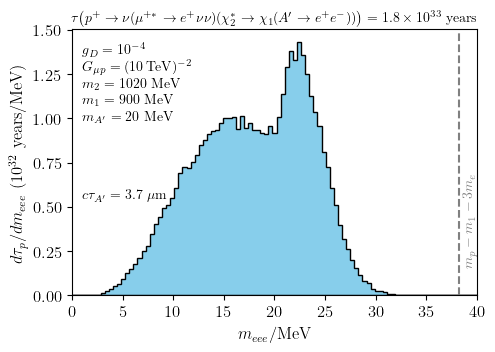

In [130]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(0, 40, 100)
ax.hist(m_eee*1e3, weights=weights/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black')

# Set labels and title
ax.set_xlabel(r'$m_{eee}$/MeV')
ax.set_ylabel(r'${d \tau_{p}/d m_{eee}}$ ($10^{32}$ years/MeV)')
ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(weights.sum()*1e32, notex=True)}$ years', fontsize=10)

# ax.set_yscale('log')

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
text_box = r'\noindent$g_D = 10^{-4}$\\$G_{\mu p} = (10 \, {\rm TeV})^{-2}$\\$m_2 = 1020$ MeV\\$m_1 = 900$ MeV\\$m_{A^\prime} = 20$ MeV'
ax.text(0.025, 0.95, text_box, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.025, 0.4, fr'$c\tau_{{A^\prime}} = {Gamma_Ap(1e-4, 0.02)*1e3:.1f}$~$\mu$m', transform=ax.transAxes, fontsize=10, verticalalignment='top')


# Add the vertical dashed line
cutoff = (938.27 - 900)
ax.axvline(cutoff, linestyle='dashed', color='grey')
ax.text(cutoff+0.5, ax.get_ylim()[1]/10, r'$m_p - m_1 - 3 m_e$', rotation='vertical', color='grey', ha='left', va='bottom')


# Save the figure to a PDF file
fig.savefig('plots/ProtonDecay_model1_meee.png', bbox_inches='tight', dpi=300)

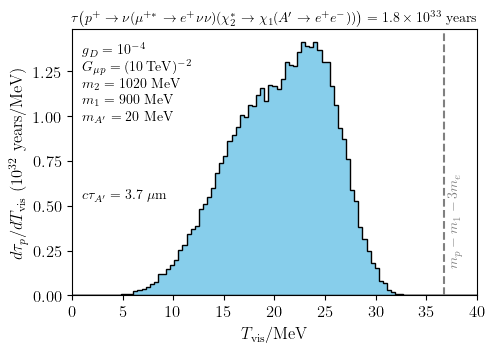

In [128]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(0, 40, 100)
ax.hist(Tvis*1e3, weights=weights/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black')

# Set labels and title
ax.set_xlabel(r'$T_{\mathrm{vis}}$/MeV')
ax.set_ylabel(r'${d \tau_{p}/d T_{\rm vis}}$ ($10^{32}$ years/MeV)')
ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(weights.sum()*1e32, notex=True)}$ years', fontsize=10)

# ax.set_yscale('log')

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
text_box = r'\noindent$g_D = 10^{-4}$\\$G_{\mu p} = (10 \, {\rm TeV})^{-2}$\\$m_2 = 1020$ MeV\\$m_1 = 900$ MeV\\$m_{A^\prime} = 20$ MeV'
ax.text(0.025, 0.95, text_box, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.025, 0.4, fr'$c\tau_{{A^\prime}} = {Gamma_Ap(1e-4, 0.02)*1e3:.1f}$~$\mu$m', transform=ax.transAxes, fontsize=10, verticalalignment='top')


# Add the vertical dashed line
cutoff = 938.27 - 900 - 3*0.511
ax.axvline(cutoff, linestyle='dashed', color='grey')
ax.text(cutoff+0.5, ax.get_ylim()[1]/10, r'$m_p - m_1 - 3 m_e$', rotation='vertical', color='grey', ha='left', va='bottom')


# Save the figure to a PDF file
fig.savefig('plots/ProtonDecay_model1_Tvis.png', bbox_inches='tight', dpi=300)